In [ ]:
# This notebook demonstrates various thresholding algorithms
# In tandem with adjustments I've made to images to try
# And pick out the clouds.

In [1]:
%matplotlib inline
import math
import os
import numpy as np
import matplotlib.image as image
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.filters import threshold_li, try_all_threshold
from pathlib import Path

In [2]:
p = Path(os.path.abspath(os.curdir))
parent = str(p.parent)

directory = parent + '/Images/20170623/'
center = (256, 252)

In [229]:
file = 'r_ut102052s16080.png' # No clouds (challenge mode)
#file = 'r_ut100056s14880.png' # Low clouds
#file = 'r_ut085307s10800.png' # High Clouds
#file = 'r_ut031003s76560.png' # Almost totally white image (super challenge mode)
img = ndimage.imread(directory + file, mode='L')

In [230]:
# Plots two images side by side.
def side_by_side(image1, title1, image2, title2):
    plt.figure(figsize=(32, 10))
    plt.subplot(141)
    plt.imshow(image1, cmap='gray')
    plt.title(title1, fontsize=20)
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(image2, cmap='gray')
    plt.title(title2, fontsize=20)
    plt.axis('off')
    plt.show()

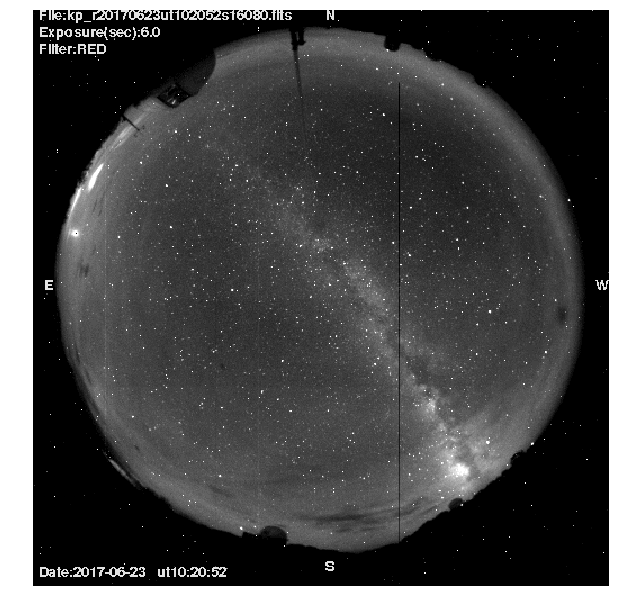

In [231]:
# Plot the original
figure = plt.figure()
figure.set_size_inches(8,8)  # 4 inches by 4 inches
axes = plt.Axes(figure, [0., 0., 1., 1.])  # 0 - 100% size of figure
axes.set_axis_off()
figure.add_axes(axes)
axes.imshow(img, cmap='gray')
plt.show()

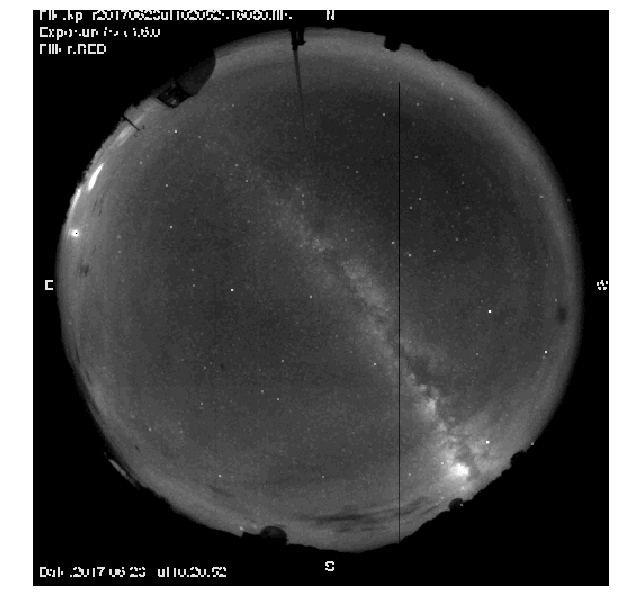

In [232]:
from skimage.filters import threshold_isodata

# Wipes out the small stars. Rip stars.
# This actually has an added benefit of wiping
# Out the stuck/hot pixels.
img2 = ndimage.grey_opening(img, size=(2,2))
#img2 = ndimage.grey_closing(img, size=(2,2))

figure = plt.figure()
figure.set_size_inches(8,8)  # 4 inches by 4 inches
axes = plt.Axes(figure, [0., 0., 1., 1.])  # 0 - 100% size of figure
axes.set_axis_off()
figure.add_axes(axes)
axes.imshow(img2, cmap='gray')
plt.show()

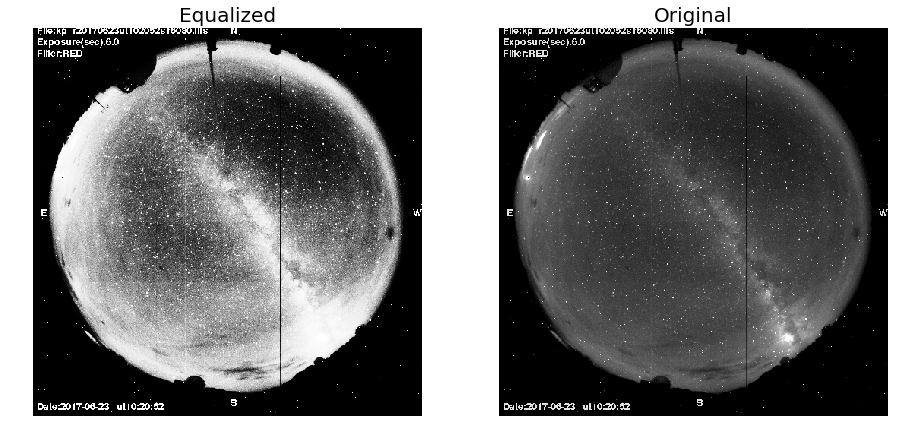

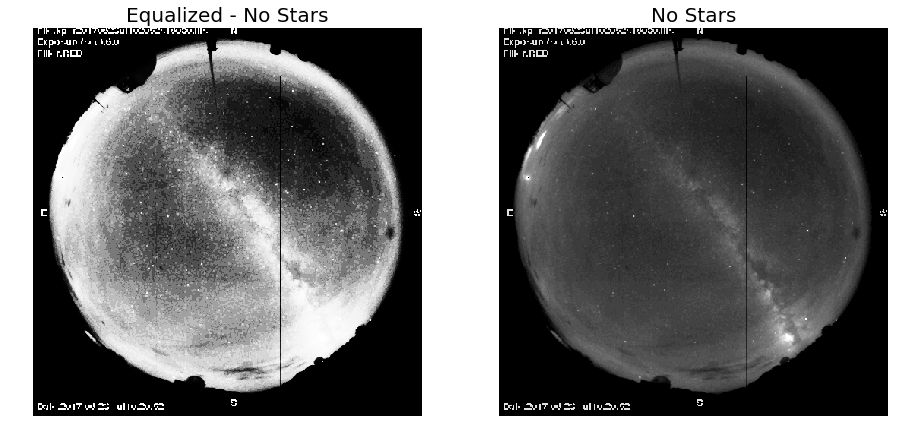

In [233]:
from skimage import exposure

img2 = ndimage.grey_opening(img, size=(2,2))

imgEq1 = exposure.equalize_hist(img)
imgEq2 = exposure.equalize_hist(img2)

side_by_side(imgEq1, "Equalized", img, "Original")
side_by_side(imgEq2, "Equalized - No Stars", img2, "No Stars")

img2 = np.copy(imgEq2)

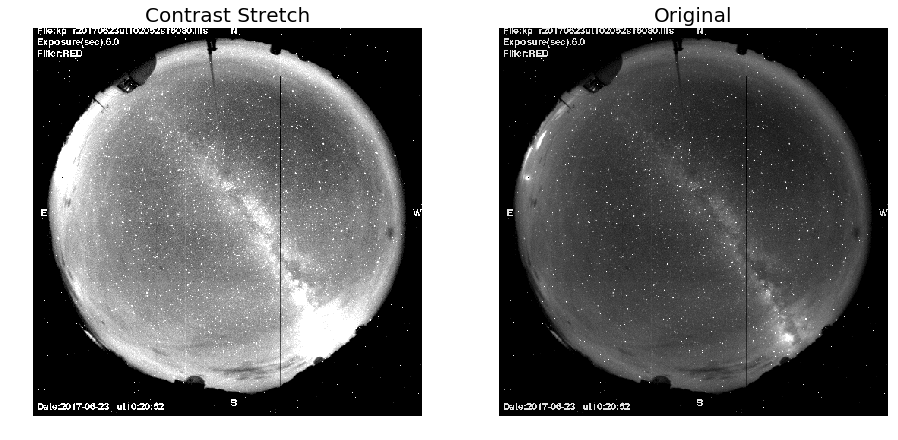

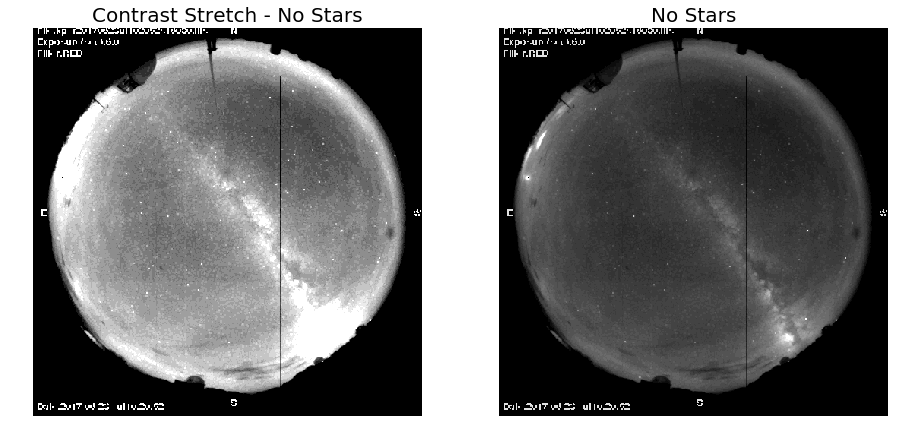

In [234]:
img2 = ndimage.grey_opening(img, size=(2,2))


p1, p2 = np.percentile(img, (4, 96))

imgEq1 = exposure.rescale_intensity(img, in_range=(p1, p2))

p1, p2 = np.percentile(img2, (4, 96))
imgEq2 = exposure.rescale_intensity(img2, in_range=(p1, p2))

side_by_side(imgEq1, "Contrast Stretch", img, "Original")
side_by_side(imgEq2, "Contrast Stretch - No Stars", img2, "No Stars")

if not np.array_equal(imgEq1, np.zeros(imgEq1.shape)):
    img2 = np.copy(imgEq2)

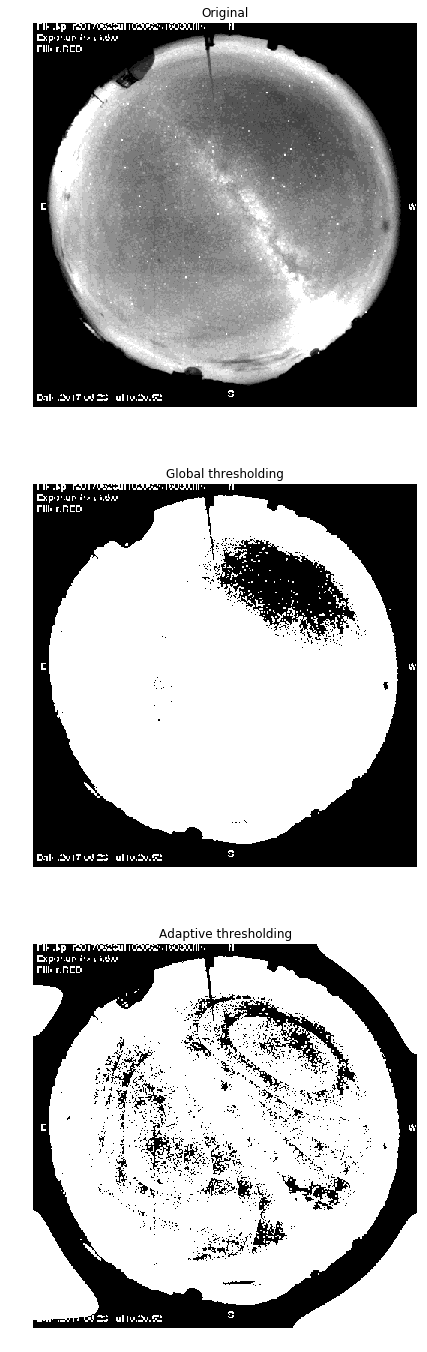

In [235]:
# Difference in local and global thresholding
from skimage.filters import threshold_otsu, threshold_local


image = np.copy(img2)

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 175
adaptive_thresh = threshold_local(image, block_size, offset=18)
binary_adaptive = image > adaptive_thresh

fig, axes = plt.subplots(nrows=3, figsize=(21, 24))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_adaptive)
ax[2].set_title('Adaptive thresholding')

for a in ax:
    a.axis('off')

plt.show()

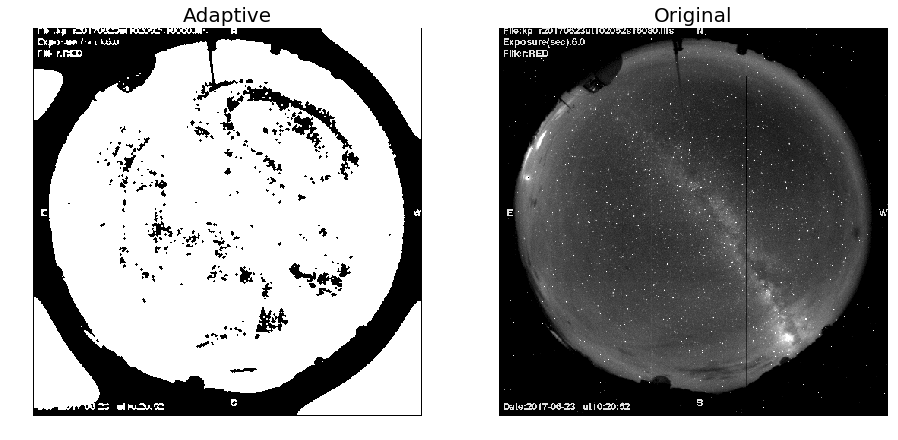

In [236]:
# Wipe out speckling
struct = [[True, True, True],[True, True, True],[True, True, True]]
img6 = ndimage.binary_closing(binary_adaptive)#, struct)

side_by_side(img6, "Adaptive", img, 'Original')

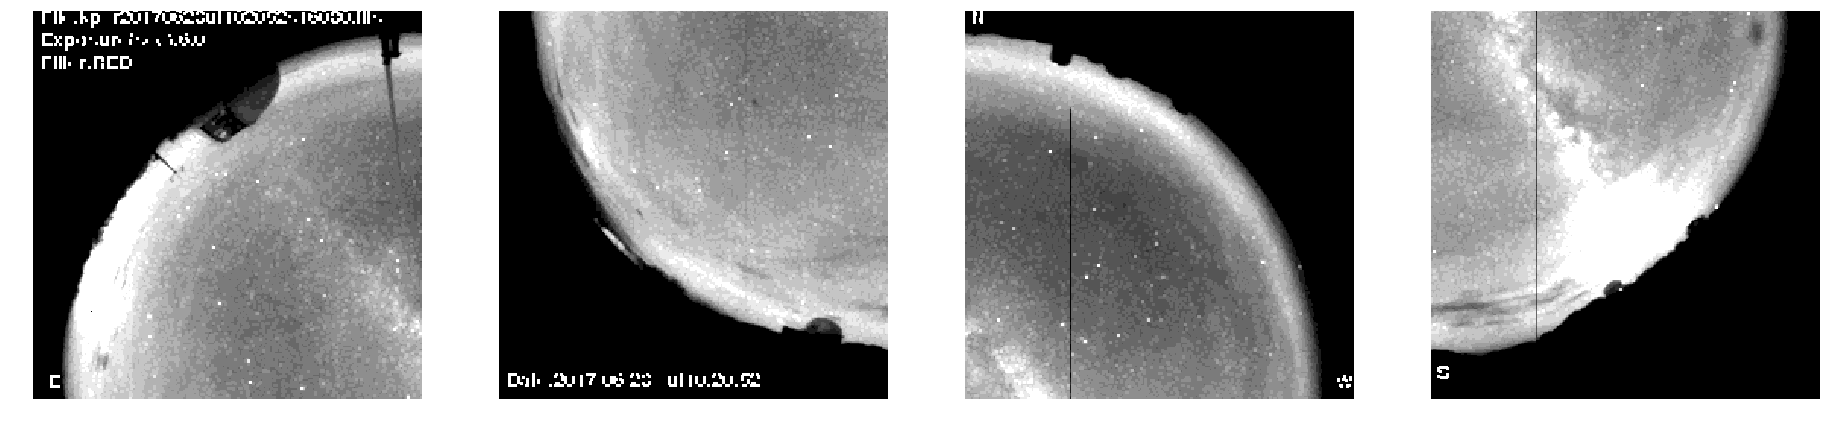

In [237]:
# Next three cells split the image in 4 and threshold each segment individually
imgT = np.copy(img2)
half = imgT.shape[0] // 2
topleft = imgT[0:half, 0:half]
bottomleft = imgT[half:img2.shape[1], 0:half]
topright = imgT[0:half, half:img2.shape[0]]
bottomright = imgT[half:img2.shape[1], half:img2.shape[0]]

plt.figure(figsize=(32, 10))
plt.subplot(141)
plt.imshow(topleft, cmap='gray')
plt.axis('off')
plt.subplot(142)
plt.imshow(bottomleft, cmap='gray')
plt.axis('off')
plt.subplot(143)
plt.imshow(topright, cmap='gray')
plt.axis('off')
plt.subplot(144)
plt.imshow(bottomright, cmap='gray')
plt.axis('off')

plt.show()

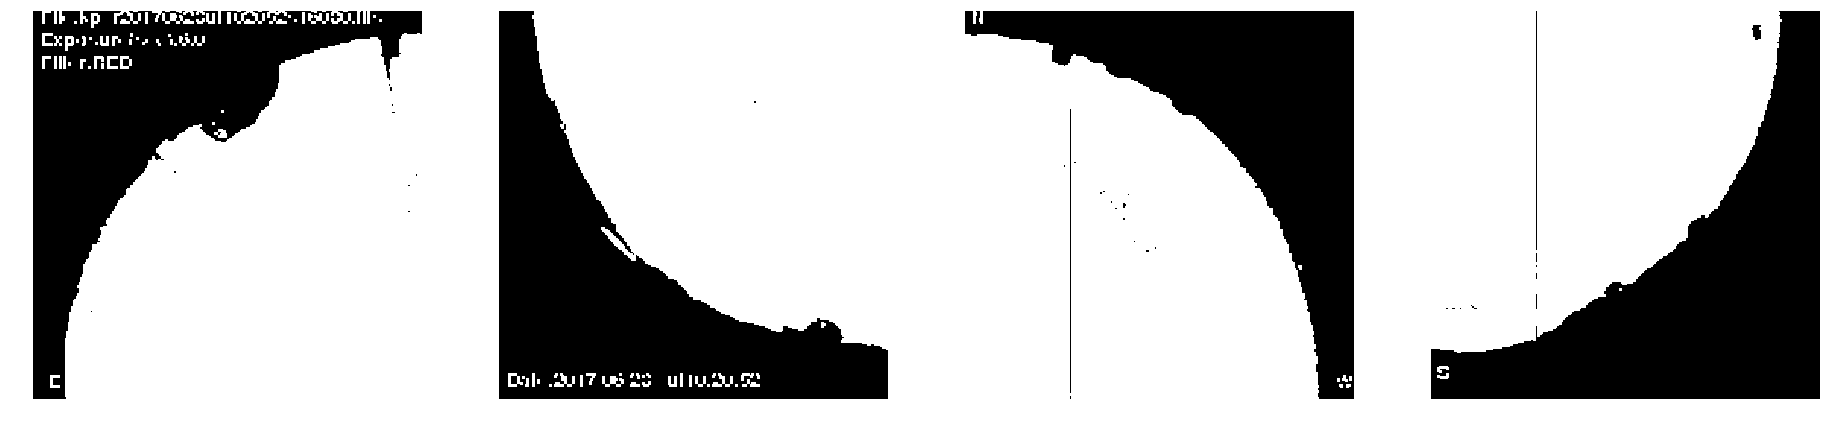

In [238]:
from skimage.filters import threshold_niblack

thresh = threshold_isodata(topleft)
topleft2 = np.where(topleft > thresh, 255, 0)
thresh = threshold_isodata(topright)
topright2 = np.where(topright > thresh, 255, 0)
thresh = threshold_isodata(bottomleft)
bottomleft2 = np.where(bottomleft > thresh, 255, 0)
thresh = threshold_isodata(bottomright)
bottomright2 = np.where(bottomright > thresh, 255, 0)

plt.figure(figsize=(32, 10))
plt.subplot(141)
plt.imshow(topleft2, cmap='gray')
plt.axis('off')
plt.subplot(142)
plt.imshow(bottomleft2, cmap='gray')
plt.axis('off')
plt.subplot(143)
plt.imshow(topright2, cmap='gray')
plt.axis('off')
plt.subplot(144)
plt.imshow(bottomright2, cmap='gray')
plt.axis('off')

plt.show()

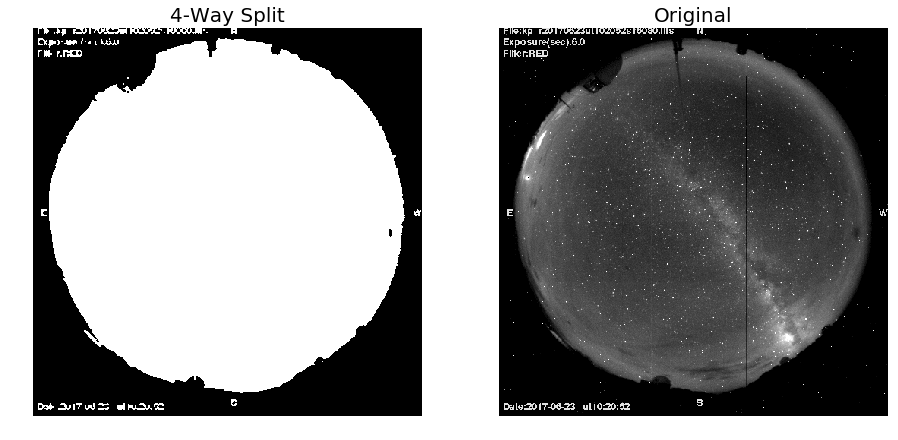

In [243]:
imgT = np.zeros(img2.shape)
imgT[0:half, 0:half] = topleft2
imgT[half:img2.shape[1], 0:half] = bottomleft2
imgT[0:half, half:img2.shape[0]] = topright2
imgT[half:img2.shape[1], half:img2.shape[0]] = bottomright2

# Wipe out speckling
imgT = ndimage.binary_closing(imgT)#, [[True, True, True]])

side_by_side(imgT, '4-Way Split', img, 'Original')


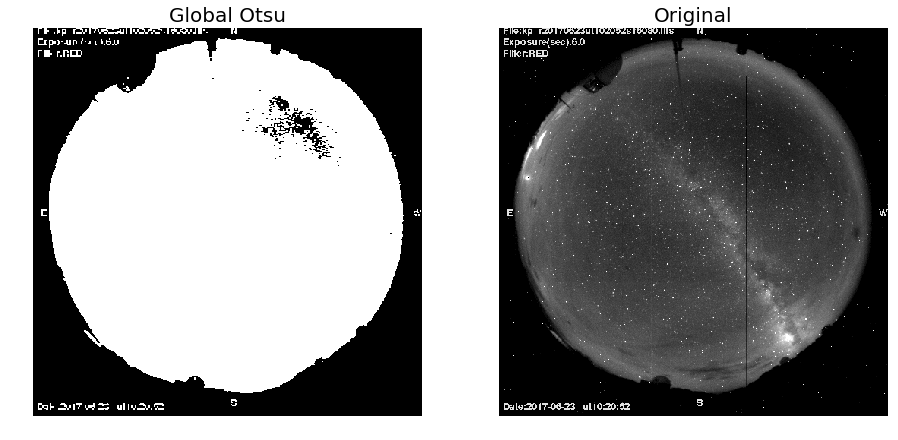

In [240]:
#from skimage.filters import threshold_triangle

# Testing Otsu alone
global_otsu = threshold_otsu(img2)

imgO2 = (img2 >= global_otsu)
imgO2 = ndimage.binary_closing(imgO2, [[True, True]])

side_by_side(imgO2, 'Global Otsu', img, 'Original')


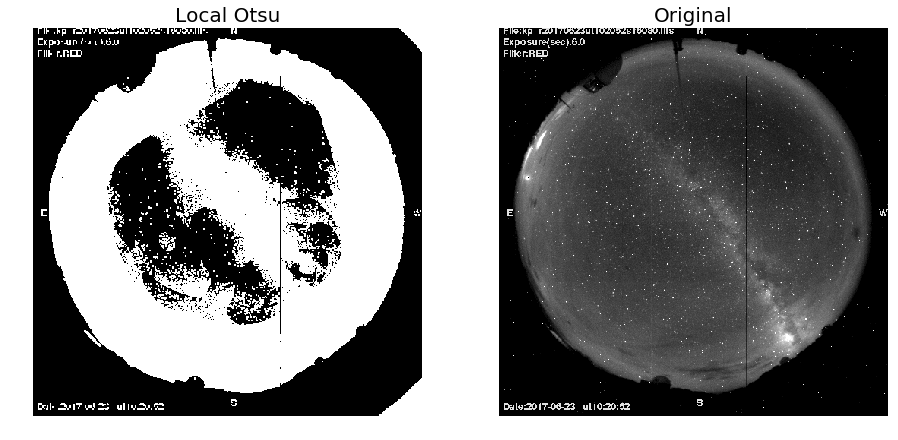

In [241]:
# Localized Otsu thresholding.
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank

radius = 100
selem = disk(radius)

local_otsu = rank.otsu(img2, selem)

imgO = (img2 >= local_otsu)

plt.figure(figsize=(32, 10))
plt.subplot(141)
plt.imshow(imgO, cmap='gray')
plt.title('Local Otsu', fontsize=20)
plt.axis('off')
plt.subplot(142)
plt.imshow(img, cmap='gray')
plt.title('Original', fontsize=20)
plt.axis('off')
plt.show()